In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os,sys
import pylab as plt
%matplotlib inline

import glob


In [2]:
src_dir = '../src'
sys.path.append(src_dir)
from jsd import jsdalpha

In [3]:
src_meta = '../../gutenberg/src/'
sys.path.append(src_meta)
from metaquery import meta_query


In [4]:
# Load meta data

In [5]:
meta=meta_query(path=src_meta+'../metadata/metadata.csv')

# Most downloaded books (in english)

In [6]:
# meta.get_df()

In [7]:
list_authors = []
Smax = 10
nmin=20
S = 0

meta.reset()
meta.filter_lang('en',how='only')
meta.filter_downloads(-1)

for author in list(meta.get_df()['author']):
    meta.reset()
    meta.filter_lang('en',how='only')
    meta.filter_author(author)
    list_pg_tmp = meta.get_ids()
    n = len(list_pg_tmp)
    if n>=nmin and author not in list_authors:
        list_authors += [author]
        S+=1
        print(author,n)
    if S==Smax:
        break

Austen, Jane 22
Conrad, Joseph 69
Wilde, Oscar 41
Carroll, Lewis 28
Dickens, Charles 141
Twain, Mark 202
Melville, Herman 25
Stevenson, Robert Louis 90
Doyle, Arthur Conan 106
Tolstoy, Leo, graf 47


In [8]:
list_authors += ['All']
list_books = []

lang = 'en'
for author in list_authors:
    meta.reset()
    meta.filter_lang(lang,how='any')
    if author=='All':
        pass
    else:
        meta.filter_author(author)
    books_tmp = meta.get_ids()
    list_books += [books_tmp]

In [9]:
[len(h) for h in list_books]

[22, 69, 41, 28, 141, 202, 25, 90, 106, 47, 46477]

In [10]:
# arr_alpha = np.array([0.0,1.0,2.0])
arr_alpha = np.linspace(0.0,2.0,21)

Npair = 1000
weights = False ## standard 1/2,1.2
normalized = True ## 0<=divergence <=1

path_read = '../../gutenberg/data/counts/'

list_jsdalpha_in = []
list_jsdalpha_out = []
list_labels = []
for i_s,s in enumerate(list_authors[:-1]):
    print(s)
    list_jsd_in_tmp = []
    list_jsd_out_tmp = []
    books_tmp=list_books[i_s]
    books_all = list_books[-1]
    for i_Npair in range(Npair):
        ## 1st book from the subject
        book_sel = True
        while book_sel== True:
            pg1, = np.random.choice(books_tmp,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg1)
            filename1 = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename1):
                book_sel = False
        ## 2nd book: from the subject - IN
        book_sel = True
        while book_sel== True:
            pg2_in, = np.random.choice(books_tmp,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_in)
            filename2_in = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_in) and pg1!=pg2_in:
                book_sel = False 
        ## 2nd book: NOT from the subject - OUT
        book_sel = True
        while book_sel== True:
            pg2_out, = np.random.choice(books_all,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_out)
            filename2_out = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_out) and pg1!=pg2_out:
                book_sel = False        

        jsd_in = jsdalpha(filename1,filename2_in,alpha=arr_alpha,weights=weights,normalized=normalized)
        jsd_out = jsdalpha(filename1,filename2_out,alpha=arr_alpha,weights=weights,normalized=normalized)

        list_jsd_in_tmp += [jsd_in]
        list_jsd_out_tmp += [jsd_out]

    list_jsdalpha_in += [list_jsd_in_tmp]
    list_jsdalpha_out += [list_jsd_out_tmp]

Austen, Jane
Conrad, Joseph
Wilde, Oscar
Carroll, Lewis
Dickens, Charles
Twain, Mark
Melville, Herman
Stevenson, Robert Louis
Doyle, Arthur Conan
Tolstoy, Leo, graf


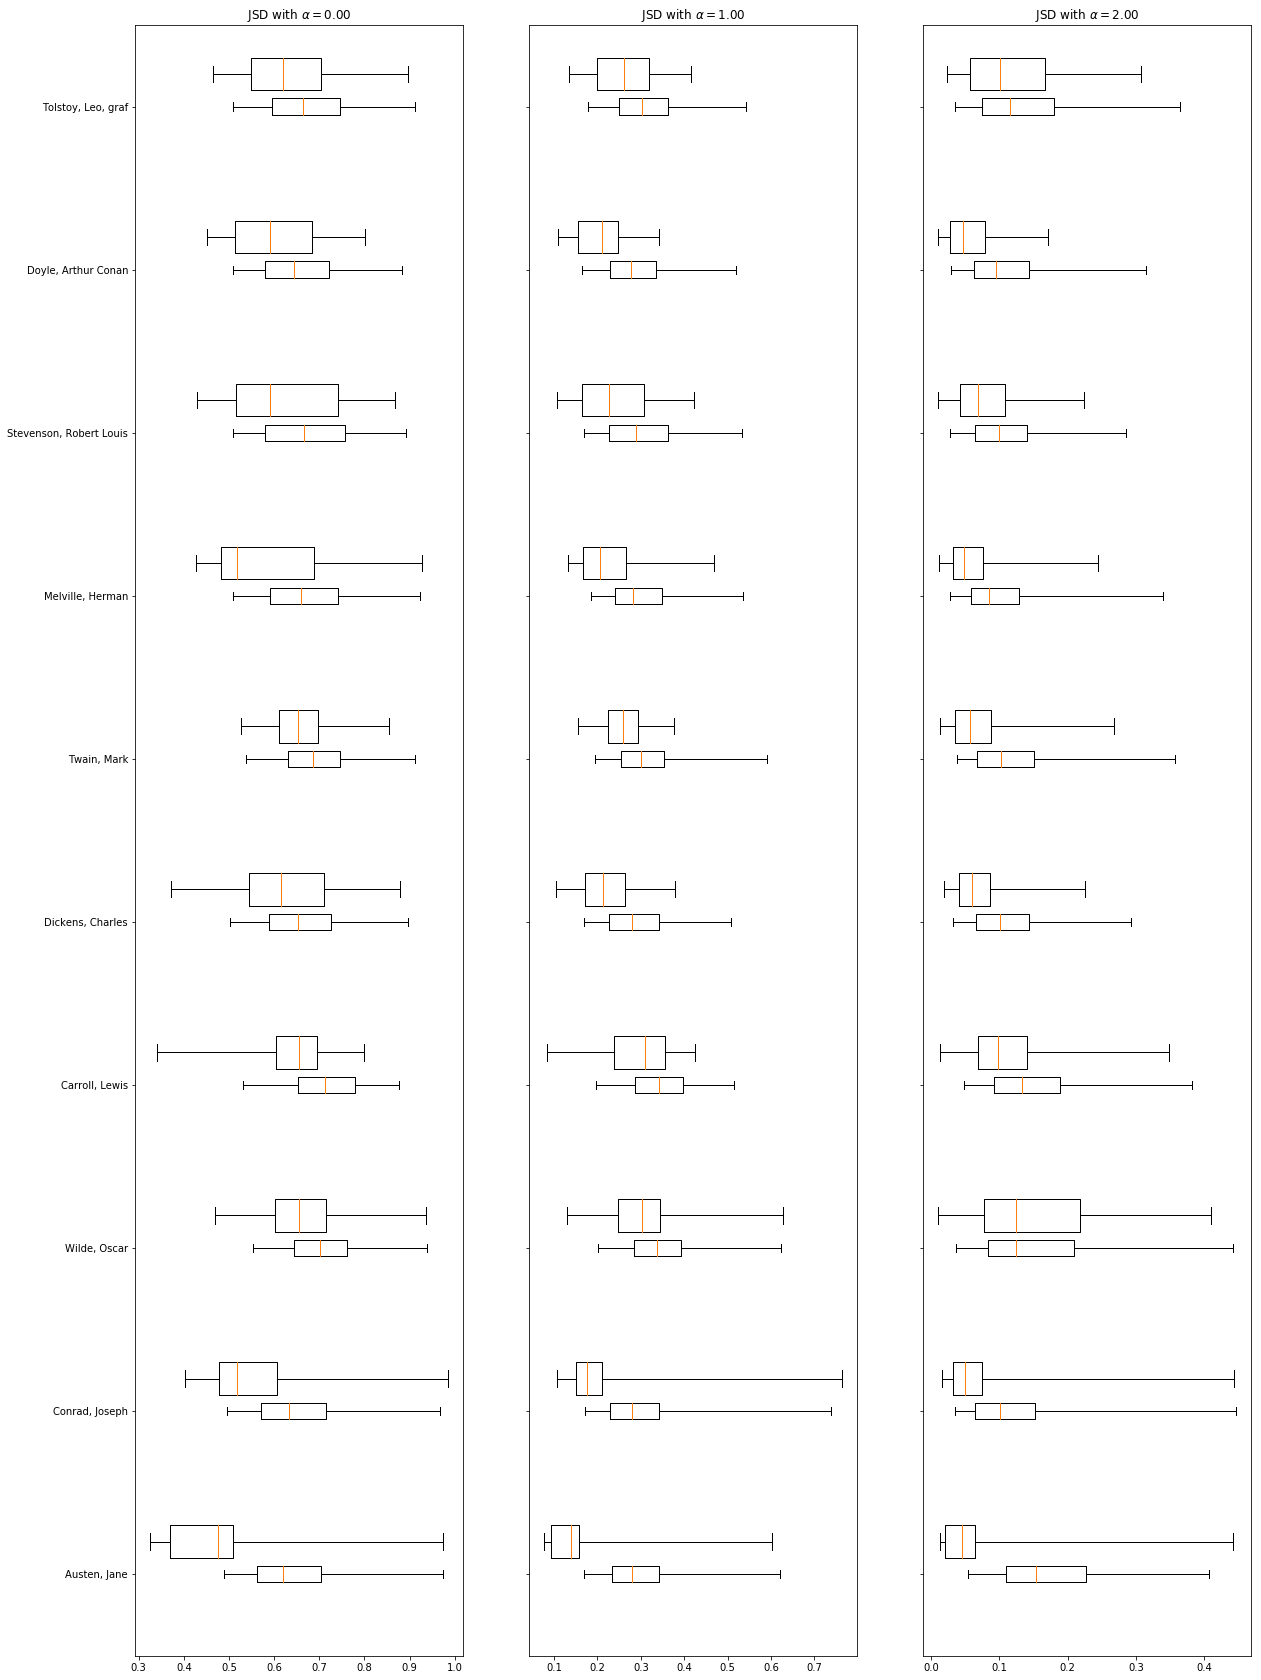

In [11]:
alpha_plot = [0.0,1.0,2.0]
f=plt.figure(figsize = (20,30))
i_plot = 0
for i_alpha,alpha in enumerate(arr_alpha):
    if alpha in alpha_plot:
        ax=f.add_subplot(1,3,i_plot+1)
        list_jsd_in_plot = [ [h[i_alpha] for h in jsd_tmp] for jsd_tmp in list_jsdalpha_in ]
        list_jsd_out_plot = [ [h[i_alpha] for h in jsd_tmp] for jsd_tmp in list_jsdalpha_out ]
        x = np.arange(Smax)
        h=-0.2
        ## within distances: large box
        _ =ax.boxplot(list_jsd_in_plot,positions=x,
                      vert=False,whis=[2.5,97.5],labels=list_authors[:-1],sym='',widths=0.2)
        ## across distances: small box
        _ =ax.boxplot(list_jsd_out_plot,positions=x+h,
                      vert=False,whis=[2.5,97.5],labels=list_authors[:-1],sym='',widths=0.1)

        _ = ax.set_title(r'JSD with $\alpha = %.2f$'%(alpha))

        if i_plot>0:
            ax.set_yticklabels([])
        i_plot+=1

In [12]:
list_acc_mu = []
list_acc_std = []

for i_alpha,alpha in enumerate(arr_alpha):
    list_acc_tmp = []

    for i_S,s in enumerate(list_authors[:-1]):
        n_acc = 0
        jsd_tmp_in = [h[i_alpha] for h in list_jsdalpha_in[i_S]]
        jsd_tmp_out = [h[i_alpha] for h in list_jsdalpha_out[i_S]]
        for i in range(Npair):
            din = jsd_tmp_in[i]
            dout=jsd_tmp_out[i]
            if din<dout:
                n_acc+=1
        list_acc_tmp += [n_acc/Npair]
#         print(n_acc/Npair)
#     print(np.mean(list_acc_tmp))
#     print(np.std(list_acc_tmp))
    list_acc_mu+=[np.mean(list_acc_tmp)]    
    list_acc_std+=[np.std(list_acc_tmp)]



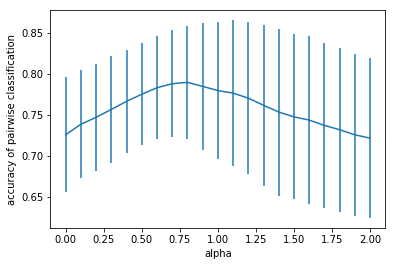

In [13]:
x=arr_alpha
y=list_acc_mu
yerr=np.array(list_acc_std)#/np.sqrt(Smax)

# yerr=np.array(list_acc_std)/np.sqrt(Smax)
_=plt.errorbar(x,y,yerr=yerr)
plt.xlabel('alpha')
plt.ylabel('accuracy of pairwise classification')